In [31]:
from matplotlib import pyplot as plt
import numpy as np

In [32]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [33]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [34]:
np.set_printoptions(precision=2, suppress=True)

In [35]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = os.path.expandvars("$HOME/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta")
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /Users/michal/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945


In [36]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [37]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [38]:
LEVEL = 30

In [39]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [40]:
np.set_printoptions(precision=3, suppress=True)

In [41]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [42]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [43]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [44]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [77]:
FUSSY_THRESHOLD = 0.2

class FussyGraphDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_neural(cnf)
        if sug_var is None:
            print("Fussy cut")
            return None
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
                
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
                    
        
        if best_prob < FUSSY_THRESHOLD:
            print("I", input_cnf)
            print("P", policy_probs)
            return None
        else:
            return best_svar


In [78]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e3 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [79]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [80]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, ShortCommonDPLL)
    compute_and_print_steps(sats, FussyGraphDPLL)
    logfile.flush()

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:10<00:00,  1.36s/it]


Within 1e3 steps solved 10 problems out of 10
#Sats: 10; avg step: 150.40; stdev step: 216.15; avg error: 1.30; stdev error: 2.10


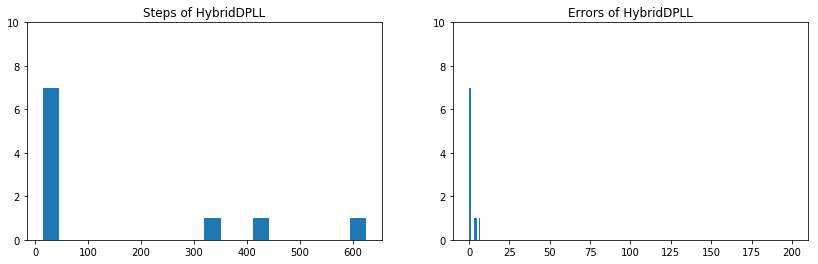

100%|██████████| 10/10 [00:00<00:00, 52.13it/s]


Within 1e3 steps solved 10 problems out of 10
#Sats: 10; avg step: 203.80; stdev step: 213.58; avg error: 2.30; stdev error: 1.73


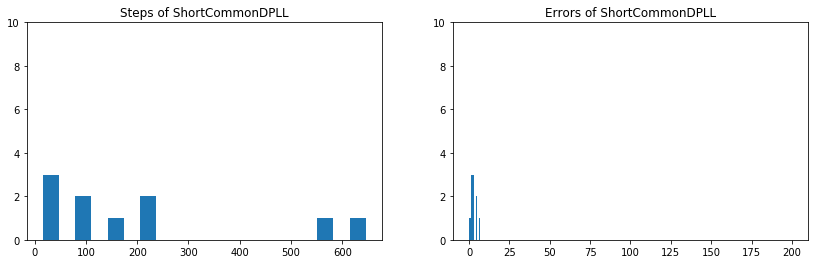

  0%|          | 0/10 [00:00<?, ?it/s]

I (~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~a)&(~a)&(~a)&(~a)&(a)
P [[[0.166 0.178]]]
Fussy cut


 70%|███████   | 7/10 [00:15<00:05,  1.85s/it]

I (d)&(d|g)&(~g|d)&(~g|d)&(~g|d)&(g)&(d)&(~d)&(d)&(~g|~d)&(~g)&(~g)&(~g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.168 0.184]
  [0.528 0.528]
  [0.528 0.528]
  [0.184 0.168]]]
Fussy cut


 90%|█████████ | 9/10 [00:20<00:02,  2.07s/it]

I (n)&(~n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.178 0.166]]]
Fussy cut
I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.

100%|██████████| 10/10 [00:26<00:00,  3.36s/it]


Within 1e3 steps solved 9 problems out of 10
#Sats: 9; avg step: 124.11; stdev step: 208.35; avg error: 0.22; stdev error: 0.42


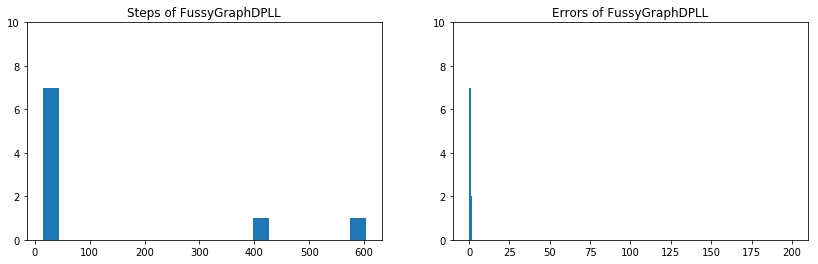

In [82]:
print_all(10, 200, 15)

In [ ]:
print_all(10, 200, 8)

In [ ]:
print_all(10, 200, 10)

In [ ]:
print_all(10, 200, 12)

In [ ]:
print_all(10, 200, 14)

In [ ]:
print_all(10, 200, 16)

In [ ]:
print_all(10, 200, 18)

In [ ]:
print_all(10, 200, 20)

In [ ]:
print_all(10, 500, 25, light=True)

In [ ]:
print_all(10, 500, 30, light=True)

In [ ]:
print_all(10, 1000, 40, light=True)

In [ ]:
print_all(10, 1000, 50, light=True)

In [ ]:
print_all(10, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 90, light=True)

In [ ]:
print_all(10, 1000, 40, light=True)

In [ ]:
print_all(100, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 60, light=True)